# Multi-label Emotion Classification
Data is about emotion detection in Indonesian user comments.<br>
Source: [emotion_riza](https://dataturks.com/projects/rizki.fauzi/emotion_riza)<br>
*The JSON data has been converted to multi-label csv data

There are 8 labels in classifying the comments:
- trust
- fear
- surprise
- sadness
- disgust
- anger
- anticipation
- joy

Source:
- [emotion_riza dataset (in JSON)](https://dataturks.com/projects/rizki.fauzi/emotion_riza)
- ["NB-SVM strong linear baseline" kernel](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline)
- [Word Cloud from a Pandas dataframe](https://mikulskibartosz.name/word-cloud-from-a-pandas-dataframe-f3203cbf757)

In [2]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Looking at The Data
The training data contains a row per comment, with the text of the comment and 8 different labels

In [3]:
train = pd.read_csv('../input/multi-label_emotion.csv')
train.head()

,text,trust,fear,surprise,sadness,disgust,anger,anticipation,joy
0,@04Nakula @jokowi @prabowo @Gerindra @Dailymot...,0,0,0,0,0,0,0,1
1,@Achmadr06327297 @fadlizon @Gerindra @prabowo ...,0,0,0,0,0,0,0,1
2,@Gerindra @PKSejahtera @prabowo Seandainya sek...,0,1,0,0,0,0,0,0
3,@fadlizon @Gerindra @prabowo Saya dukung pak p...,0,0,0,0,0,0,0,1
4,@Gerindra @PKSejahtera Mencari yang setia dan ...,1,0,0,0,0,0,0,0


In [4]:
train.describe()

,trust,fear,surprise,sadness,disgust,anger,anticipation,joy
count,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000,8690.000000
mean,0.216456,0.071922,0.010587,0.084925,0.063751,0.114845,0.167664,0.268124
std,0.411852,0.258373,0.102352,0.278786,0.244324,0.318853,0.373589,0.443008
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


133.1126582278481 199.1904592927695 2 5558


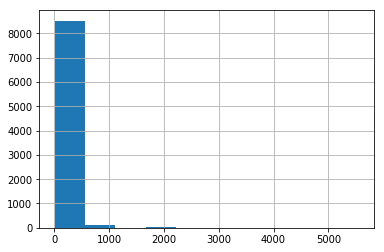

In [6]:
# The length of the comments
lens = train.text.str.len()
print(lens.mean(), lens.std(), lens.min(), lens.max())

lens.hist();

## Building The Model
Creating a bag of words representation, as a term document matrix. We use N-grams.

In [29]:
train.shape[0] #rows

8690

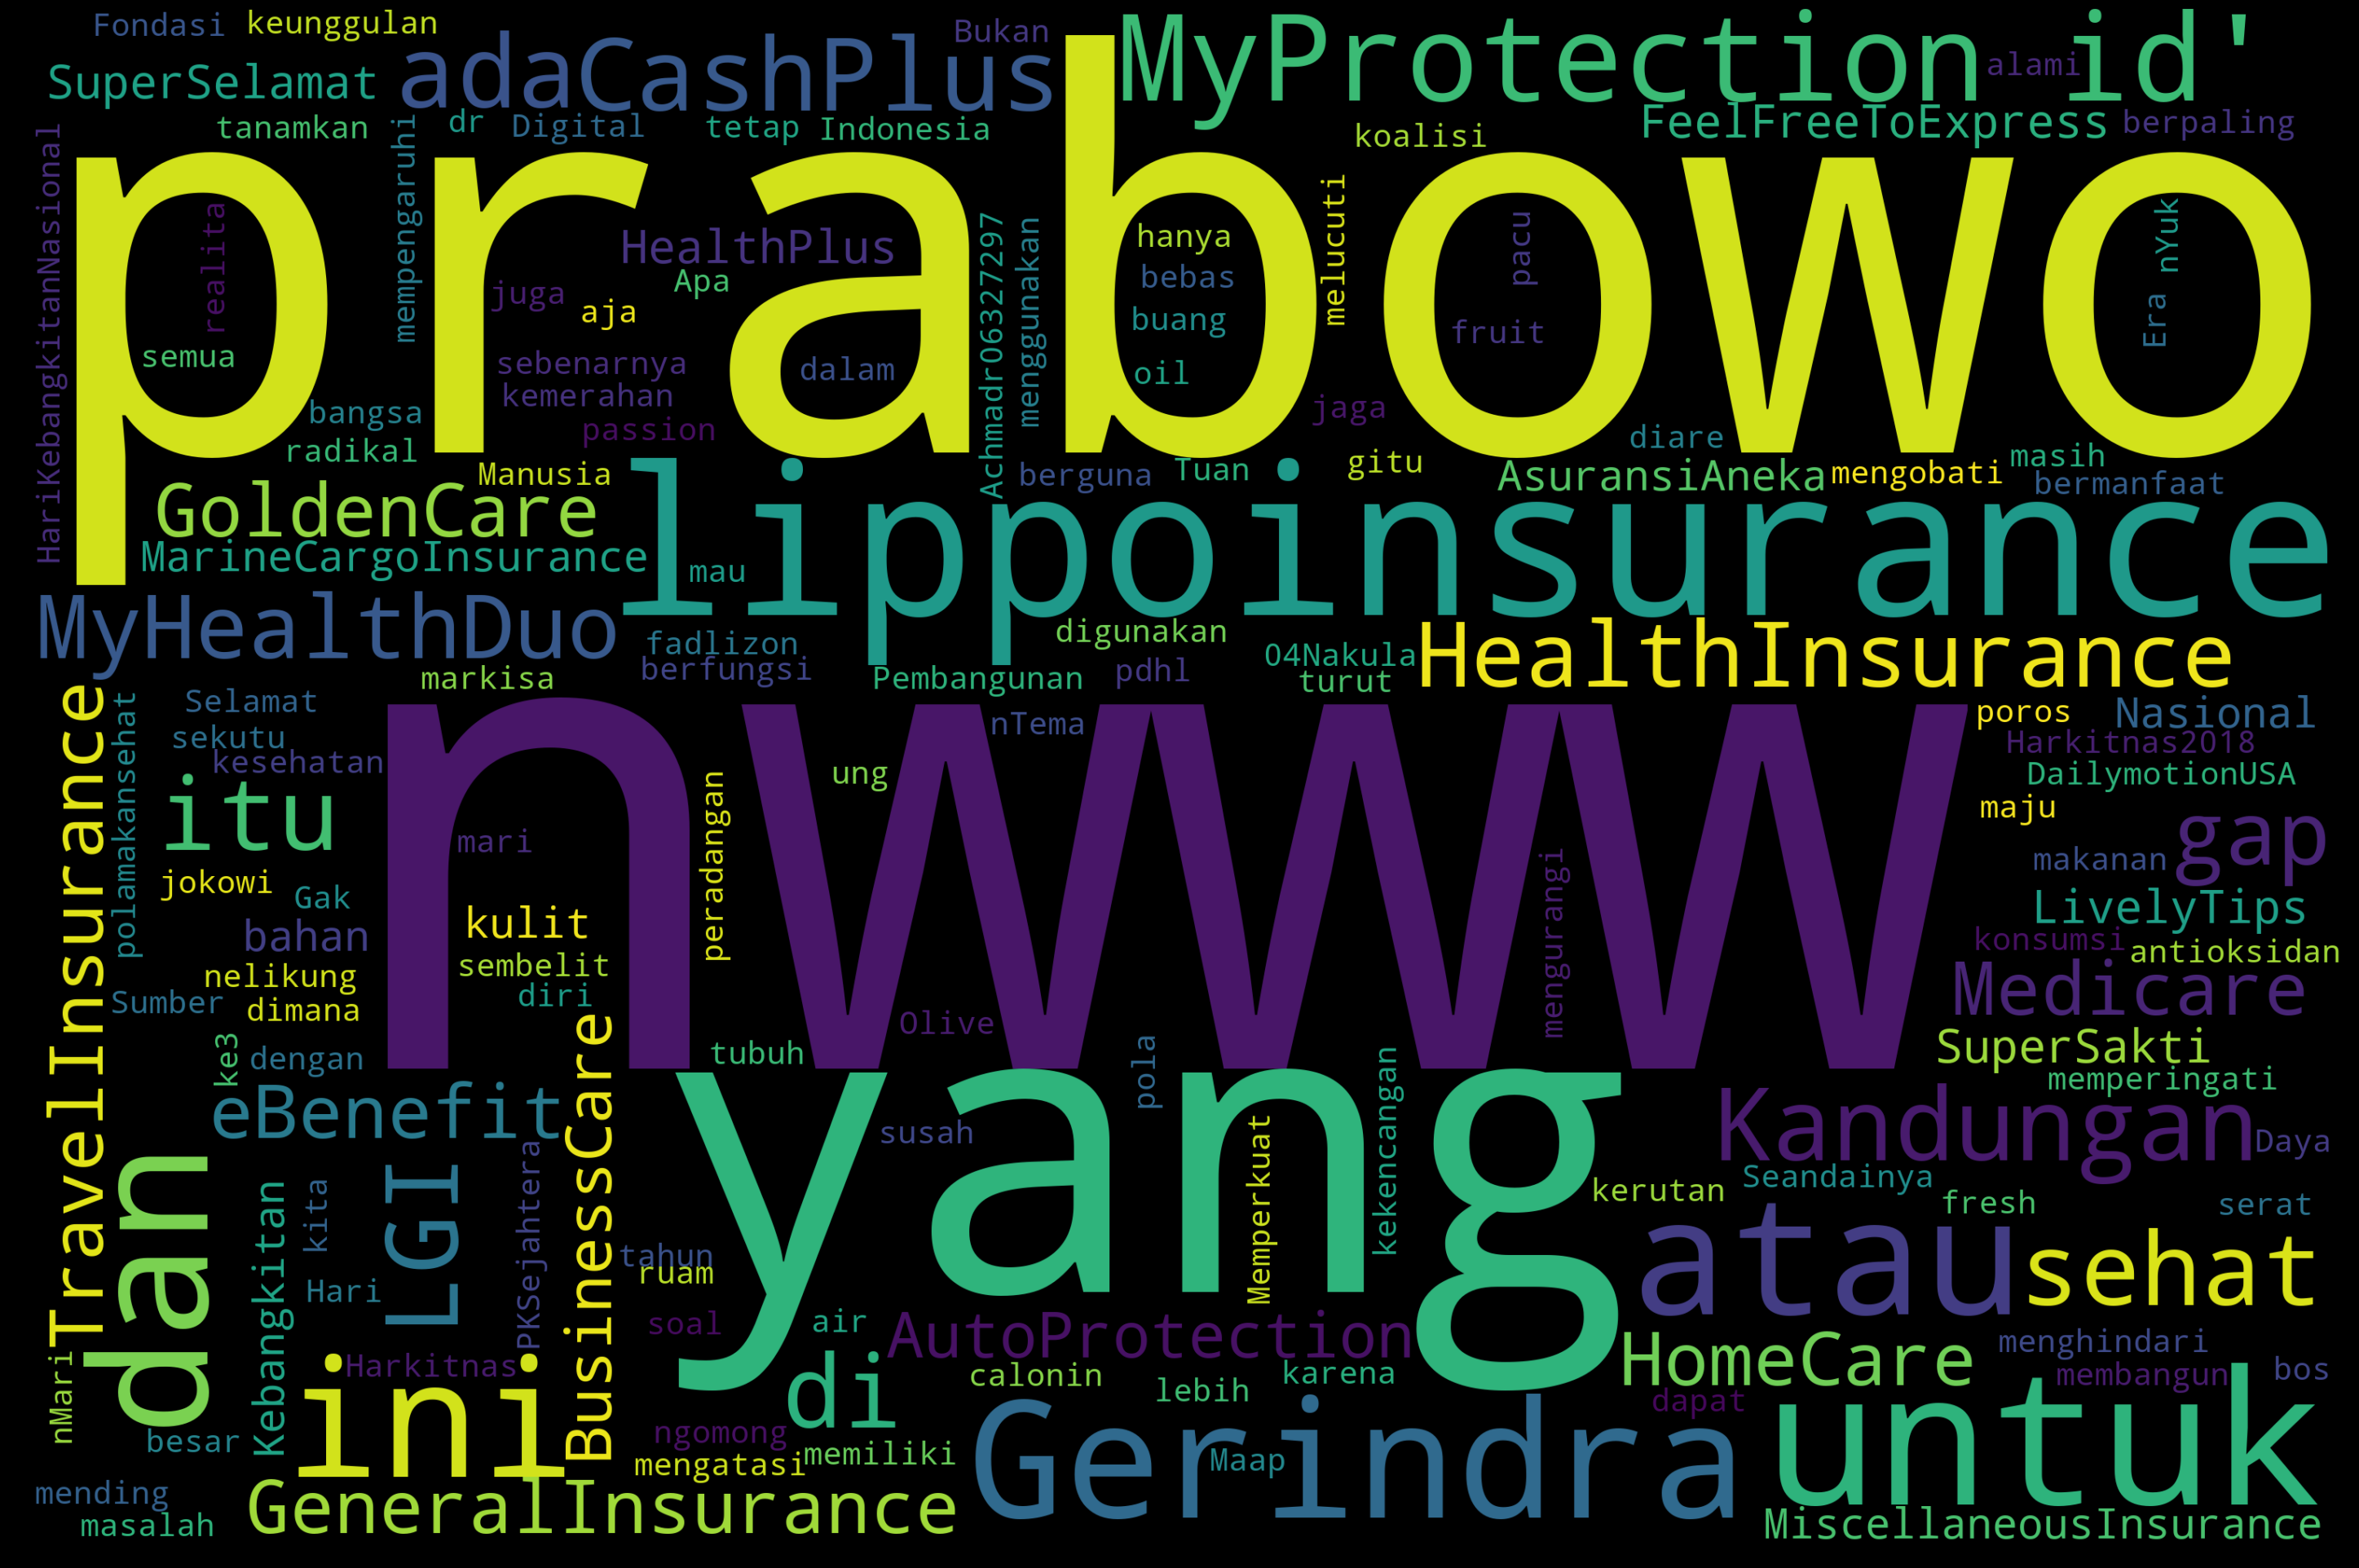

In [38]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = str(train.text.values)

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black'
).generate(text)

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [39]:
import re, string

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    # string which is not needed but appears frequently
    no_need = ['@', 'yang', 'dan', 'di', 'karena', 'untuk', 'juga', 'tahun', 'dr', 'atau', 'prabowo', 'jokowi']
    
    words = re_tok.sub(r' \1 ', s).split()
    return [x for x in words if not x in no_need]

In [40]:
tokenize(train.text[0])

['04Nakula',
 'Gerindra',
 'DailymotionUSA',
 'pdhl',
 'poros',
 'ke3',
 'ini',
 'sebenarnya',
 'mau',
 'nelikung',
 'koalisi',
 'prabowo…']

In [47]:
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

trn_term_doc = vec.fit_transform(train['text'])

# Use the same dataset to test
test = train
test_term_doc = vec.transform(test['text'])

In [48]:
trn_term_doc
test_term_doc

<8690x23903 sparse matrix of type '<class 'numpy.float64'>'
	with 233574 stored elements in Compressed Sparse Row format>

In [49]:
# Basic naive bayes feature equation
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [53]:
x = trn_term_doc
test_x = test_term_doc

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [54]:
labels = ['trust', 'fear', 'surprise', 'sadness', 'disgust', 'anger', 'anticipation', 'joy']

preds = np.zeros((len(test), len(labels)))

for i, j in enumerate(labels):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit trust
fit fear
fit surprise


/home/hamdi/venv/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit sadness
fit disgust
fit anger
fit anticipation
fit joy


In [73]:
result = pd.concat([test["text"], pd.DataFrame(preds, columns = labels)], axis=1)
result

,text,trust,fear,surprise,sadness,disgust,anger,anticipation,joy
0,@04Nakula @jokowi @prabowo @Gerindra @Dailymot...,0.112002,0.017248,0.000893,0.005696,0.011435,0.021320,0.092687,0.666140
1,@Achmadr06327297 @fadlizon @Gerindra @prabowo ...,0.048469,0.013294,0.001032,0.008580,0.034999,0.137443,0.081526,0.590001
2,@Gerindra @PKSejahtera @prabowo Seandainya sek...,0.026870,0.828798,0.001070,0.009078,0.047856,0.034583,0.114540,0.032974
3,@fadlizon @Gerindra @prabowo Saya dukung pak p...,0.291382,0.010671,0.000991,0.003120,0.014584,0.019771,0.025829,0.727910
4,@Gerindra @PKSejahtera Mencari yang setia dan ...,0.781938,0.013986,0.001167,0.019902,0.011885,0.030686,0.052377,0.124435
5,#kom4 Edhy P. @Gerindra #sumsel1: kita berhara...,0.645209,0.010296,0.000966,0.006272,0.017357,0.017736,0.052626,0.276219
6,@Gerindra Memang pak prabowo sdh pernah mimipi...,0.097204,0.012415,0.001203,0.016419,0.033759,0.883437,0.070736,0.043066
7,@fadlizon @prabowo @Gerindra Kompas medianya c...,0.025492,0.012818,0.001062,0.000925,0.108973,0.872593,0.025318,0.030573
8,@04Nakula @jokowi @prabowo @Gerindra @Dailymot...,0.112002,0.017248,0.000893,0.005696,0.011435,0.021320,0.092687,0.666140
9,@Achmadr06327297 @fadlizon @Gerindra @prabowo ...,0.048469,0.013294,0.001032,0.008580,0.034999,0.137443,0.081526,0.590001


In [76]:
# Save result in CSV
print(result.loc[5])
print(train.loc[5])

text            #kom4 Edhy P. @Gerindra #sumsel1: kita berhara...
trust                                                    0.645209
fear                                                     0.010296
surprise                                              0.000965721
sadness                                                0.00627235
disgust                                                 0.0173566
anger                                                   0.0177363
anticipation                                            0.0526264
joy                                                      0.276219
Name: 5, dtype: object
